In [1]:
import torch
import torchbearer
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import numpy as np
import pickle
from torchbearer.callbacks import LiveLossPlot
from itertools import product
import gc
from scipy.ndimage import gaussian_filter
import numpy as np
from matplotlib import pyplot as plt
import random
import torch.nn.functional as F
from torch import nn
import sys
import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

In [4]:
 # define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = F.dropout(out, 0.2)        
        out = self.fc2(out)        
        out = F.relu(out)
        out = self.fc3(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out
    
# Define the ANN  network
class NetworkControl(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NetworkControl, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = F.dropout(out, 0.2)        
        out = self.fc2(out)        
        out = F.relu(out)
        out = F.dropout(out, 0.2)        
        out = self.fc3(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out
    
    
class BetterCNNforDistillation(nn.Module):
    def __init__(self):
        super(BetterCNNforDistillation, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, (5, 5), padding=0)
        self.conv2 = nn.Conv2d(32, 64, (3, 3), padding=0)
        self.fc1 = nn.Linear(64 * 5**2, 1024)
        self.fc2 = nn.Linear(1024, 50)
        self.fc3 = nn.Linear(50, 10)

            
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        out = self.conv2(out)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        out = F.dropout(out, 0.2)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out

In [5]:
def fgsm_attack(model, loss, images, labels, eps) :
    
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True
            
    outputs = model(images)
    
    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()
    
    attack_images = images + eps*images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)
    
    return attack_images

In [9]:
#plot

trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)
trainset.data = trainset.data[0:27105]
trainset.targets = trainset.targets[0:27105]


sigma_values = [0, 0.5, 1.0, 1.5, 2.0, 2.5]
variance_values = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
blur_acc_control = []
blur_acc_sleep = []
blur_acc_finetune_noise = []
blur_acc_finetune_blur = []
blur_acc_dis = []
noise_acc_control = []
noise_acc_sleep = []
noise_acc_finetune_noise = []
noise_acc_finetune_blur = []
noise_acc_dis = []

for i in range(len(sigma_values)):
    
    j = i
    
    #blur data
    trainset = MNIST(".", train=True, download=True, transform=transform)
    testset = MNIST(".", train=False, download=True, transform=transform)
    trainset.data = trainset.data[0:27105]
    trainset.targets = trainset.targets[0:27105]



    # function to blur each MNIST image
    def blur(x, sig):
        return gaussian_filter(x, sigma=sig)
    

    # Distort the test set #
    for i in range(len(testset)):
        # gaussian blur the image with the chosen sigma value
        blurredImage = blur(testset.test_data[i].numpy(), sigma_values[j])
        # update the training set with the blurred image
        testset.test_data[i] = torch.from_numpy(blurredImage)
    
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
    testloader = DataLoader(testset, batch_size=128, shuffle=True)
    
    #test the controlled network
    model = torch.load('save_ann.pkl')
    loss_function = nn.CrossEntropyLoss()
    # live_loss_plot = LiveLossPlot()
    optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    # trial = torchbearer.Trial(model, optimiser, loss_function, callbacks=[live_loss_plot], metrics=['loss', 'accuracy']).to(device)
    trial = torchbearer.Trial(model, optimiser, loss_function,metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(trainloader, test_generator=testloader)
    results = trial.evaluate(data_key=torchbearer.TEST_DATA)
    print(results)
    blur_acc_control.append(100.0 * results["test_acc"])
    
    #test the sleeping network
    model = torch.load('save_sleep.pkl')
    loss_function = nn.CrossEntropyLoss()
    # live_loss_plot = LiveLossPlot()
    optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    # trial = torchbearer.Trial(model, optimiser, loss_function, callbacks=[live_loss_plot], metrics=['loss', 'accuracy']).to(device)
    trial = torchbearer.Trial(model, optimiser, loss_function,metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(trainloader, test_generator=testloader)
    results = trial.evaluate(data_key=torchbearer.TEST_DATA)
    print(results)
    blur_acc_sleep.append(100.0 * results["test_acc"])
    
    #test the fine-tuning-blur network
    model = torch.load('save_blur.pkl')
    loss_function = nn.CrossEntropyLoss()
    # live_loss_plot = LiveLossPlot()
    optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(trainloader, test_generator=testloader)
    results = trial.evaluate(data_key=torchbearer.TEST_DATA)
    print(results)
    blur_acc_finetune_blur.append(100.0 * results["test_acc"])
    
    #test the fine-tuning-noise network
    model = torch.load('save_noise.pkl')
    loss_function = nn.CrossEntropyLoss()
    # live_loss_plot = LiveLossPlot()
    optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(trainloader, test_generator=testloader)
    results = trial.evaluate(data_key=torchbearer.TEST_DATA)
    print(results)
    blur_acc_finetune_noise.append(100.0 * results["test_acc"])
    
    #test the distillion network
    model = torch.load('save_dis.pkl')
    model.eval()

    # Compute the model accuracy on the test set
    correct = 0
    total = 0

    for data in testloader:
        inputs, labels = data
        inputs = torch.reshape(inputs, [-1, 1,28,28])
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, 1)
        correct += (predictions == labels).sum().float()
        total += len(labels)
    print('Test Accuracy: %2.2f %%' % ((100.0 * correct) / total))
    blur_acc_dis.append(((100.0 * correct) / total).item())
    
    
    
    #noise data
    trainset = MNIST(".", train=True, download=True, transform=transform)
    testset = MNIST(".", train=False, download=True, transform=transform)
    trainset.data = trainset.data[0:27105]
    trainset.targets = trainset.targets[0:27105]
    
    def noise(x, var):
        return x + var * x.std() * np.random.random(x.shape)

    for i in range(len(testset)):
        # add gaussian noise to the image with the chosen variance value
        noisyImage = noise(testset.test_data[i].numpy(), variance_values[j])
        # update the training set with the noise image
        testset.test_data[i] = torch.from_numpy(noisyImage)
    
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
    testloader = DataLoader(testset, batch_size=128, shuffle=True)
    
    #test the controlled network
    model = torch.load('save_ann.pkl')
    loss_function = nn.CrossEntropyLoss()
    # live_loss_plot = LiveLossPlot()
    optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(trainloader, test_generator=testloader)
    results = trial.evaluate(data_key=torchbearer.TEST_DATA)
    print(results)
    noise_acc_control.append(100.0 * results["test_acc"])
    
    #test the sleeping network
    model = torch.load('save_sleep.pkl')
    loss_function = nn.CrossEntropyLoss()
    # live_loss_plot = LiveLossPlot()
    optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(trainloader, test_generator=testloader)
    results = trial.evaluate(data_key=torchbearer.TEST_DATA)
    print(results)
    noise_acc_sleep.append(100.0 * results["test_acc"])
    
    #test the fine-tuning-blur network
    model = torch.load('save_blur.pkl')
    loss_function = nn.CrossEntropyLoss()
    # live_loss_plot = LiveLossPlot()
    optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(trainloader, test_generator=testloader)
    results = trial.evaluate(data_key=torchbearer.TEST_DATA)
    print(results)
    noise_acc_finetune_blur.append(100.0 * results["test_acc"])
    
    #test the fine-tuning-noise network
    model = torch.load('save_noise.pkl')
    loss_function = nn.CrossEntropyLoss()
    # live_loss_plot = LiveLossPlot()
    optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(trainloader, test_generator=testloader)
    results = trial.evaluate(data_key=torchbearer.TEST_DATA)
    print(results)
    noise_acc_finetune_noise.append(100.0 * results["test_acc"])
    
    #test the distillion network
    model = torch.load('save_dis.pkl')
    model.eval()
    # Compute the model accuracy on the test set
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data
        inputs = torch.reshape(inputs, [-1, 1,28,28])
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, 1)
        correct += (predictions == labels).sum().float()
        total += len(labels)
    print('Test Accuracy: %2.2f %%' % ((100.0 * correct) / total))
    noise_acc_dis.append(((100.0 * correct) / total).item())


{'test_loss': 1.5647623538970947, 'test_acc': 0.9345999956130981}



{'test_loss': 1.5746958255767822, 'test_acc': 0.9328999519348145}



{'test_loss': 1.601085901260376, 'test_acc': 0.8978999853134155}



{'test_loss': 1.606365442276001, 'test_acc': 0.8784999847412109}
Test Accuracy: 91.06 %



{'test_loss': 1.5630444288253784, 'test_acc': 0.9368999600410461}



{'test_loss': 1.576521396636963, 'test_acc': 0.9321999549865723}



{'test_loss': 1.6045453548431396, 'test_acc': 0.8978999853134155}



{'test_loss': 1.6060320138931274, 'test_acc': 0.8834999799728394}
Test Accuracy: 91.10 %



{'test_loss': 1.5719881057739258, 'test_acc': 0.9350000023841858}



{'test_loss': 1.5801975727081299, 'test_acc': 0.9323999881744385}



{'test_loss': 1.6048853397369385, 'test_acc': 0.9013999700546265}



{'test_loss': 1.6096822023391724, 'test_acc': 0.8834999799728394}
Test Accuracy: 90.74 %



{'test_loss': 1.831343650817871, 'test_acc': 0.8017999529838562}



{'test_loss': 1.8332927227020264, 'test_acc': 0.8388999700546265}



{'test_loss': 1.805745244026184, 'test_acc': 0.8104000091552734}



{'test_loss': 1.720850944519043, 'test_acc': 0.8402999639511108}
Test Accuracy: 75.78 %



{'test_loss': 1.5933043956756592, 'test_acc': 0.9286999702453613}



{'test_loss': 1.602210521697998, 'test_acc': 0.9277999997138977}



{'test_loss': 1.6180121898651123, 'test_acc': 0.892799973487854}



{'test_loss': 1.6285626888275146, 'test_acc': 0.8734999895095825}
Test Accuracy: 89.83 %



{'test_loss': 1.9445338249206543, 'test_acc': 0.6908000111579895}



{'test_loss': 1.9286240339279175, 'test_acc': 0.7676999568939209}



{'test_loss': 1.9007023572921753, 'test_acc': 0.7240999937057495}



{'test_loss': 1.7682768106460571, 'test_acc': 0.8120999932289124}
Test Accuracy: 69.40 %



{'test_loss': 1.6446360349655151, 'test_acc': 0.9073999524116516}



{'test_loss': 1.652984619140625, 'test_acc': 0.914199948310852}



{'test_loss': 1.6450425386428833, 'test_acc': 0.8837999701499939}



{'test_loss': 1.663956642150879, 'test_acc': 0.8477999567985535}
Test Accuracy: 87.21 %



{'test_loss': 2.0245003700256348, 'test_acc': 0.5783999562263489}



{'test_loss': 1.9989632368087769, 'test_acc': 0.6776999831199646}



{'test_loss': 1.9777311086654663, 'test_acc': 0.6214999556541443}



{'test_loss': 1.805928111076355, 'test_acc': 0.7793999910354614}
Test Accuracy: 62.95 %



{'test_loss': 1.7362710237503052, 'test_acc': 0.8643999695777893}



{'test_loss': 1.7400120496749878, 'test_acc': 0.8905999660491943}



{'test_loss': 1.694706678390503, 'test_acc': 0.8652999997138977}



{'test_loss': 1.728931188583374, 'test_acc': 0.7976999878883362}
Test Accuracy: 82.40 %



{'test_loss': 2.088667869567871, 'test_acc': 0.46209999918937683}



{'test_loss': 2.0635159015655518, 'test_acc': 0.5616999864578247}



{'test_loss': 2.0428497791290283, 'test_acc': 0.5159000158309937}



{'test_loss': 1.8443318605422974, 'test_acc': 0.7457999587059021}
Test Accuracy: 55.90 %



{'test_loss': 1.8547677993774414, 'test_acc': 0.7857999801635742}



{'test_loss': 1.8536840677261353, 'test_acc': 0.8417999744415283}



{'test_loss': 1.766892671585083, 'test_acc': 0.8334999680519104}



{'test_loss': 1.8231570720672607, 'test_acc': 0.7159000039100647}
Test Accuracy: 74.40 %



{'test_loss': 2.1405344009399414, 'test_acc': 0.3684999942779541}



{'test_loss': 2.1192166805267334, 'test_acc': 0.4603999853134155}



{'test_loss': 2.103740930557251, 'test_acc': 0.41999998688697815}



{'test_loss': 1.8864057064056396, 'test_acc': 0.7031999826431274}
Test Accuracy: 47.16 %


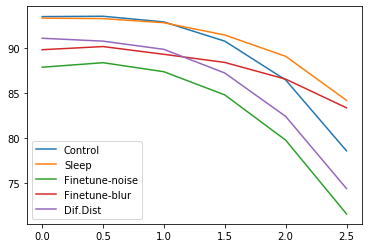

In [10]:
plt.plot(sigma_values, blur_acc_control, label='Control')
plt.plot(sigma_values, blur_acc_sleep, label='Sleep')
plt.plot(sigma_values, blur_acc_finetune_noise, label='Finetune-noise')
plt.plot(sigma_values, blur_acc_finetune_blur, label='Finetune-blur')
plt.plot(sigma_values, blur_acc_dis, label='Dif.Dist')
plt.legend()
plt.show()

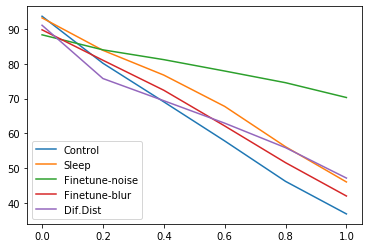

In [11]:
plt.plot(variance_values, noise_acc_control, label='Control')
plt.plot(variance_values, noise_acc_sleep, label='Sleep')
plt.plot(variance_values, noise_acc_finetune_noise, label='Finetune-noise')
plt.plot(variance_values, noise_acc_finetune_blur, label='Finetune-blur')
plt.plot(variance_values, noise_acc_dis, label='Dif.Dist')
plt.legend()
plt.show()

In [34]:
eps = [0,0.04,0.08,0.12,0.16,0.2]
fgsm_acc_control = []
fgsm_acc_sleep = []
fgsm_acc_finetune_noise = []
fgsm_acc_finetune_blur = []
fgsm_acc_dis = []
for i in range(len(eps)):
     #FGSM   
    print("Attack Image & Predicted Label")
    loss_function = nn.CrossEntropyLoss()

    

    trainset = MNIST(".", train=True, download=True, transform=transform)
    testset = MNIST(".", train=False, download=True, transform=transform)
    trainset.data = trainset.data[0:27105]
    trainset.targets = trainset.targets[0:27105]
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
    testloader = DataLoader(testset, batch_size=128, shuffle=True)
    
    
    model = torch.load('save_ann.pkl')
    model.eval()
    loss_function = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    for images, labels in testloader:
    
        images = fgsm_attack(model, loss_function, images, labels, eps[i]).to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, pre = torch.max(outputs.data, 1)

        total += labels.shape[0]
        correct += (pre == labels).sum()
    
    #     imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    
    print('Accuracy of test text: %f %%' % (100 * float(correct) / total))
    fgsm_acc_control.append(100 * float(correct) / total)
    
    model = torch.load('save_sleep.pkl')
    model.eval()
    loss_function = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    for images, labels in testloader:
    
        images = fgsm_attack(model, loss_function, images, labels, eps[i]).to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, pre = torch.max(outputs.data, 1)

        total += labels.shape[0]
        correct += (pre == labels).sum()
    
    #     imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    
    print('Accuracy of test text: %f %%' % (100 * float(correct) / total))
    fgsm_acc_sleep.append(100 * float(correct) / total)
    
    model = torch.load('save_noise.pkl')
    model.eval()
    loss_function = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    for images, labels in testloader:
    
        images = fgsm_attack(model, loss_function, images, labels, eps[i]).to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, pre = torch.max(outputs.data, 1)

        total += labels.shape[0]
        correct += (pre == labels).sum()
    
    #     imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    
    print('Accuracy of test text: %f %%' % (100 * float(correct) / total))
    fgsm_acc_finetune_noise.append(100 * float(correct) / total)
    
    model = torch.load('save_blur.pkl')
    model.eval()
    loss_function = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    for images, labels in testloader:
    
        images = fgsm_attack(model, loss_function, images, labels, eps[i]).to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, pre = torch.max(outputs.data, 1)

        total += labels.shape[0]
        correct += (pre == labels).sum()
    
    #     imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    
    print('Accuracy of test text: %f %%' % (100 * float(correct) / total))
    fgsm_acc_finetune_blur.append(100 * float(correct) / total)
    
    model = torch.load('save_dis.pkl')
    model.eval()
    loss_function = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    for images, labels in testloader:
        images = torch.reshape(images, [-1, 1,28,28])
        images = fgsm_attack(model, loss_function, images, labels, eps[i]).to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, pre = torch.max(outputs.data, 1)

        total += labels.shape[0]
        correct += (pre == labels).sum()
    
    #     imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    
    print('Accuracy of test text: %f %%' % (100 * float(correct) / total))
    fgsm_acc_dis.append(100 * float(correct) / total)

Attack Image & Predicted Label
Accuracy of test text: 93.600000 %
Accuracy of test text: 92.840000 %
Accuracy of test text: 88.230000 %
Accuracy of test text: 89.810000 %
Accuracy of test text: 89.900000 %
Attack Image & Predicted Label
Accuracy of test text: 81.660000 %
Accuracy of test text: 81.350000 %
Accuracy of test text: 74.540000 %
Accuracy of test text: 75.900000 %
Accuracy of test text: 81.760000 %
Attack Image & Predicted Label
Accuracy of test text: 56.180000 %
Accuracy of test text: 58.970000 %
Accuracy of test text: 52.260000 %
Accuracy of test text: 52.800000 %
Accuracy of test text: 72.390000 %
Attack Image & Predicted Label
Accuracy of test text: 25.610000 %
Accuracy of test text: 30.440000 %
Accuracy of test text: 28.190000 %
Accuracy of test text: 27.400000 %
Accuracy of test text: 60.640000 %
Attack Image & Predicted Label
Accuracy of test text: 9.560000 %
Accuracy of test text: 11.210000 %
Accuracy of test text: 12.950000 %
Accuracy of test text: 10.630000 %
Accura

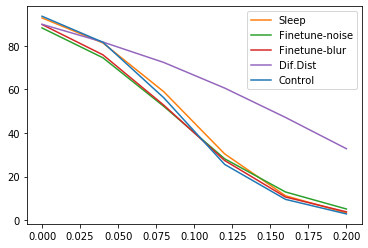

In [39]:
plt.errorbar(eps, fgsm_acc_control, label='Control')
plt.plot(eps, fgsm_acc_sleep, label='Sleep')
plt.plot(eps, fgsm_acc_finetune_noise, label='Finetune-noise')
plt.plot(eps, fgsm_acc_finetune_blur, label='Finetune-blur')
plt.plot(eps, fgsm_acc_dis, label='Dif.Dist')
plt.legend()
plt.show()